## Functions to identify winners and filter only for races we have winners

---
- Only requires the candidate files
- Uses the 'Incumbent' tag from subsequent race to identfy winner in current race (assumes they run again, data leakage)
- Filter out races in years we don't have an identified winner from method above

In [1]:
pip install fuzzywuzzy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from pyspark.sql import SparkSession
import pyspark.sql.types as typ
import pyspark.sql.functions as F
from pyspark.sql import DataFrame
from functools import reduce
from pyspark.sql.functions import col, asc
from pyspark.sql import SQLContext
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType, DoubleType, DateType
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import plotly.graph_objects as go
import pandas as pd

/home/hs4cf/.local/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
spark = SparkSession \
    .builder \
    .getOrCreate()

sc = spark.sparkContext

### Step 1: Load in the multi-year candidate files

In [4]:
def parse_file(file_name, file_header):
    '''Tool to load in an FEC file with associated header and produce a Spark Dataframe'''   

    #load data frame and split by delimiter  
    df_temp = sc.textFile(file_name).map(lambda row: [elem for elem in row.split('|')])
    
    #load separate header csv file and prepare schema 
    #assumes all values are STRING TYPE for simplicity
    head_temp = pd.read_csv(file_header)
    fields = [*[typ.StructField(h[:], typ.StringType(), True) for h in head_temp.columns]]
    schema = typ.StructType(fields)
    
    #finalize spark dataframe
    df = spark.createDataFrame(df_temp, schema)
    
    return df

In [5]:
#Taking all of the candidate files, reading them through parse_file and joining into a single table

#df_candidate_20 = parse_file('candidate_2020.txt', 'candidate_header_file.csv')
#df_candidate_18 = parse_file('candidate_2018.txt', 'candidate_header_file.csv')
#df_candidate_16 = parse_file('candidate_2016.txt', 'candidate_header_file.csv')


#updated based on the file structure in the repo
df_candidate_20 = parse_file('./fec_data/cn/cn20.txt', './fec_data/cn/cn_header_file.csv')
df_candidate_18 = parse_file('./fec_data/cn/cn18.txt', './fec_data/cn/cn_header_file.csv')
df_candidate_16 = parse_file('./fec_data/cn/cn16.txt', './fec_data/cn/cn_header_file.csv')


dfs = [df_candidate_20, df_candidate_18, df_candidate_16]

df_candidate = reduce(DataFrame.unionAll, dfs)

#converting to a pandas DF for ease of working with
df_candidate = df_candidate.select('*').toPandas() 

In [6]:
len(df_candidate)

22275

### Step 2: Identify WINNERS in a race

In [7]:
def identify_candidates(df, year_race, year_incumbent):
    '''
    df = dataframe, created in the step above
    year_race = string, year of the actual race where we will identify the winner (e.g., '2018')
    year_incumbent = string, election year AFTER the actual race where winner will be incumbent (e.g., '2020')    
    
    output is dataframe
    '''
    ##WINNERS
    #identify the incumbents based on year and identifier 'I' = incumbent in the documentation
    df_winners = df[(df.CAND_ELECTION_YR == year_incumbent) & (df.CAND_ICI == 'I') & (df.CAND_OFFICE != 'P')]
    #there are duplicates listed based on certain changes in status, but we only care about the unique candidate IDs who are incumbents
    df_winners = df_winners.drop_duplicates(subset = ['CAND_ID']).reset_index(drop=True)
    
    
    ##CANDIDATE
    #identify the pool of candidates in the year of the actual race
    df_candidates = df[(df.CAND_ELECTION_YR == year_race)&(df.CAND_OFFICE != 'P')]
    #same issue with duplicates
    df_candidates = df_candidates.drop_duplicates(subset = ['CAND_ID']).reset_index(drop=True)
    
    
    ##MATCHING WINNERS TO CANDIDATES
    #naming issues between years, use FUZZYWUZZY to match name strings from winner, candidate DFs
    df_candidates['WINNER'] = 0

    for name in df_candidates.CAND_NAME:
        ratio = process.extract(name, df_winners.CAND_NAME, limit = 1, scorer=fuzz.token_set_ratio)
          
        #if the match is deemed 100% (typically due to just periods, abbreviations), consider them a winner
        if ratio[0][1] == 100:
            df_candidates.loc[(df_candidates['CAND_NAME'] == name),'WINNER'] = 1
    
    ##FILTERING CANDIDATES
    #steps to filter out races we don't have a winner; use the unique office position to filter
    df_candidates['OFFICE_CONCAT'] = df_candidates['CAND_OFFICE_ST']+df_candidates['CAND_OFFICE']+df_candidates['CAND_OFFICE_DISTRICT']
    office_list = [office for office in df_candidates.loc[df_candidates['WINNER'] == 1].OFFICE_CONCAT.unique()]
    
    df_final = df_candidates.loc[df_candidates['OFFICE_CONCAT'].isin(office_list)]
    
    return df_final
    

In [8]:
df_2018 = identify_candidates(df_candidate, '2018', '2020')

In [9]:
df_2018.groupby('OFFICE_CONCAT').count()

CAND_ID  CAND_NAME  CAND_PTY_AFFILIATION  CAND_ELECTION_YR  \
OFFICE_CONCAT                                                               
AKH00                9          9                     9                 9   
ALH01                4          4                     4                 4   
ALH02                7          7                     7                 7   
ALH03                5          5                     5                 5   
ALH04                6          6                     6                 6   
...                ...        ...                   ...               ...   
WIH08                2          2                     2                 2   
WVH01                4          4                     4                 4   
WVH02                4          4                     4                 4   
WVH03               13         13                    13                13   
WYH00                7          7                     7                 7   

               CAND_OFFICE_ST  CAND_OFFICE  CAND_OFFICE_DISTRICT  CAND_ICI  \
OFFICE_CONCAT                                                                
AKH00                       9            9                     9         9   
ALH01                       4            4                     4         4   
ALH02                       7            7                     7         7   
ALH03                       5            5                     5         5   
ALH04                       6            6                     6         6   
...                       ...          ...                   ...       ...   
WIH08                       2            2                     2         2   
WVH01                       4            4                     4         4   
WVH02                       4            4                     4         4   
WVH03                      13           13                    13        13   
WYH00                       7            7                     7         7   

               CAND_STATUS  CAND_PCC  CAND_ST1  CAND_ST2  CAND_CITY  CAND_ST  \
OFFICE_CONCAT                                                                  
AKH00                    9         9         9         9          9        9   
ALH01                    4         4         4         4          4        4   
ALH02                    7         7         7         7          7        7   
ALH03                    5         5         5         5          5        5   
ALH04                    6         6         6         6          6        6   
...                    ...       ...       ...       ...        ...      ...   
WIH08                    2         2         2         2          2        2   
WVH01                    4         4         4         4          4        4   
WVH02                    4         4         4         4          4        4   
WVH03                   13        13        13        13         13       13   
WYH00                    7         7         7         7          7        7   

               CAND_ZIP  WINNER  
OFFICE_CONCAT                    
AKH00                 9       9  
ALH01                 4       4  
ALH02                 7       7  
ALH03                 5       5  
ALH04                 6       6  
...                 ...     ...  
WIH08                 2       2  
WVH01                 4       4  
WVH02                 4       4  
WVH03                13      13  
WYH00                 7       7  

[430 rows x 16 columns]

### Step 3: CONCATENATE Multiple Years of Data

In [10]:
temp_df2018 = identify_candidates(df_candidate,'2018','2020')
temp_df2016 = identify_candidates(df_candidate,'2016','2018')

df_combined = pd.concat([temp_df2016,temp_df2018])

In [11]:
df_combined.head()

CAND_ID               CAND_NAME CAND_PTY_AFFILIATION CAND_ELECTION_YR  \
0  H0CA15148             HONDA, MIKE                  DEM             2016   
1  H0CT02140      NOVAK, DARIA IRENE                  REP             2016   
2  H0DE01017            CARNEY, JOHN                  DEM             2016   
3  H0FL04033  PUESCHEL, DEBORAH KATZ                    W             2016   
4  H0FL04066         CRENSHAW, ANDER                  REP             2016   

  CAND_OFFICE_ST CAND_OFFICE CAND_OFFICE_DISTRICT CAND_ICI CAND_STATUS  \
0             CA           H                   17        I           P   
1             CT           H                   02        C           P   
2             DE           H                   00        I           P   
3             FL           H                   04        O           N   
4             FL           H                   04        I           P   

    CAND_PCC                         CAND_ST1                      CAND_ST2  \
0  C00351379  C/O CONTRIBUTION SOLUTIONS, LLC  1346 THE ALAMEDA, STE. 7-380   
1  C00589713     51 HAMMONASSETT MEADOWS ROAD                                 
2  C00460899                    P.O. BOX 2162                                 
3  C00346767      7645 SENTRY OAK CIRCLE EAST                                 
4  C00352849                 7235 BONNEVAL RD                     SUITE 228   

      CAND_CITY CAND_ST   CAND_ZIP  WINNER OFFICE_CONCAT  
0      SAN JOSE      CA      95126       0         CAH17  
1       MADISON      CT      06443       0         CTH02  
2    WILMINGTON      DE      19899       0         DEH00  
3  JACKSONVILLE      FL      32256       0         FLH04  
4  JACKSONVILLE      FL  322567506       0         FLH04

In [12]:
df_combined.WINNER.sum()

867

In [13]:
len(df_combined)

5517

----

############ NEW STUFF ###################


---
### Including Vote Totals from MIT Election Lab

In [14]:
#data from https://electionlab.mit.edu/data
df = pd.read_excel('1976-2018-house.xlsx')
df_filter18 = df[(df.year == 2018) & (df.writein == False)]
df_filter16 = df[(df.year == 2016) & (df.writein == False)]

#### 2018

In [15]:
df_house18 = df_candidate[(df_candidate.CAND_ELECTION_YR == '2018')&(df_candidate.CAND_OFFICE == 'H')]
df_house18 = df_house18.drop_duplicates(subset = ['CAND_ID']).reset_index(drop=True)

In [16]:
df_house18['CAND_ID'].groupby(df_house18.CAND_OFFICE).count()

CAND_OFFICE
H    3243
Name: CAND_ID, dtype: int64

In [17]:
df_house18['name_match'] = 0
df_house18['score_match'] = 0

In [18]:
#fuzzywuzzy match attempt between names in FEC/MIT data sets
name_match = []
score_match = []

for name in df_house18.CAND_NAME:
    ratio = process.extract(name, df_filter18.candidate, limit = 1, scorer=fuzz.token_set_ratio)
    name_match.append(ratio[0][0])
    score_match.append(ratio[0][1])   

df_house18['name_match'] = name_match
df_house18['score_match'] = score_match

In [19]:
#raw output
df_house18.head()

CAND_ID               CAND_NAME CAND_PTY_AFFILIATION CAND_ELECTION_YR  \
0  H0CA17185        KABAT, RONALD P.                  NPA             2018   
1  H0CA48024           ISSA, DARRELL                  REP             2018   
2  H0DE01025              IZZO, ROSE                  DEM             2018   
3  H0FL12101       ROSS, DENNIS ALAN                  REP             2018   
4  H0ID01253  LABRADOR, RAUL R. HON.                  REP             2018   

  CAND_OFFICE_ST CAND_OFFICE CAND_OFFICE_DISTRICT CAND_ICI CAND_STATUS  \
0             CA           H                   20        C           N   
1             CA           H                   49        I           P   
2             DE           H                   00        C           P   
3             FL           H                   15        I           P   
4             ID           H                   01        I           P   

    CAND_PCC             CAND_ST1 CAND_ST2          CAND_CITY CAND_ST  \
0  C00690545    POST OFFICE BOX 6           CARMEL-BY-THE-SEA      CA   
1  C00350520           PO BOX 760                       VISTA      CA   
2  C00548040  2115 COVENTRY DRIVE                  WILMINGTON      DE   
3  C00459461   607 LAKE MIRIAM DR                    LAKELAND      FL   
4  C00470948     1846 W RUSH ROAD                       EAGLE      ID   

    CAND_ZIP         name_match  score_match  
0  939210006  Ronald Paul Kabat           92  
1      92085        Darren Soto           61  
2  198102851          John Rose           67  
3      33813         Ross Spano           57  
4  836163636          Raul Ruiz           62

In [20]:
#downloaded to file to review manually
#df_house18.to_csv('18tempfile.csv')

In [21]:
#re-uploaded
df_h18 = pd.read_excel('18tempfile.xlsx')
df_h18 = df_h18[df_h18.match == 1]

*2018 Data:*  
auto match = 897  
manual match = 201  
total match = 1092/1208

In [22]:
df_h18['CAND_ID'].count()

1066

In [23]:
df_h18_final = df_h18.merge(df_filter18, left_on='match_id', right_index=True)

In [24]:
df_h18_final['CAND_ID'].count()

1066

### State Population data from 2010-2019 from census.gov (nst-est2019-01.xlsx renamed to uscensus_population.xlsx):
https://www2.census.gov/programs-surveys/popest/tables/2010-2019/state/totals/



In [25]:
df_pop = pd.read_excel('uscensus_population.xlsx', skiprows=[0,1,2,4,5,6,7,8,60,61,62,63,64,65,66])
df_pop=df_pop.rename(columns={"Unnamed: 0": "CAND_OFFICE_ST"})
df_pop['CAND_OFFICE_ST'] = df_pop.CAND_OFFICE_ST.astype(str)
df_pop.columns = [str(x) for x in df_pop.columns]

df_pop['CAND_OFFICE_ST'] = df_pop['CAND_OFFICE_ST'].map(lambda x: x.lstrip('.'))
df_pop

CAND_OFFICE_ST    Census  Estimates Base      2010      2011  \
0                Alabama   4779736         4780125   4785437   4799069   
1                 Alaska    710231          710249    713910    722128   
2                Arizona   6392017         6392288   6407172   6472643   
3               Arkansas   2915918         2916031   2921964   2940667   
4             California  37253956        37254519  37319502  37638369   
5               Colorado   5029196         5029319   5047349   5121108   
6            Connecticut   3574097         3574147   3579114   3588283   
7               Delaware    897934          897937    899593    907381   
8   District of Columbia    601723          601767    605226    619800   
9                Florida  18801310        18804564  18845537  19053237   
10               Georgia   9687653         9688729   9711881   9802431   
11                Hawaii   1360301         1360307   1363963   1379329   
12                 Idaho   1567582         1567657   1570746   1583910   
13              Illinois  12830632        12831572  12840503  12867454   
14               Indiana   6483802         6484051   6490432   6516528   
15                  Iowa   3046355         3046871   3050745   3066336   
16                Kansas   2853118         2853123   2858190   2869225   
17              Kentucky   4339367         4339333   4348181   4369821   
18             Louisiana   4533372         4533487   4544532   4575625   
19                 Maine   1328361         1328358   1327629   1328284   
20              Maryland   5773552         5773794   5788645   5839419   
21         Massachusetts   6547629         6547785   6566307   6613583   
22              Michigan   9883640         9884116   9877510   9882412   
23             Minnesota   5303925         5303927   5310828   5346143   
24           Mississippi   2967297         2968130   2970548   2978731   
25              Missouri   5988927         5988950   5995974   6010275   
26               Montana    989415          989407    990697    997316   
27              Nebraska   1826341         1826305   1829542   1840672   
28                Nevada   2700551         2700677   2702405   2712730   
29         New Hampshire   1316470         1316462   1316762   1320202   
30            New Jersey   8791894         8791978   8799446   8828117   
31            New Mexico   2059179         2059199   2064552   2080450   
32              New York  19378102        19378144  19399878  19499241   
33        North Carolina   9535483         9535751   9574323   9657592   
34          North Dakota    672591          672576    674715    685225   
35                  Ohio  11536504        11536751  11539336  11544663   
36              Oklahoma   3751351         3751582   3759944   3788379   
37                Oregon   3831074         3831079   3837491   3872036   
38          Pennsylvania  12702379        12702868  12711160  12745815   
39          Rhode Island   1052567         1052964   1053959   1053649   
40        South Carolina   4625364         4625366   4635649   4671994   
41          South Dakota    814180          814198    816166    823579   
42             Tennessee   6346105         6346276   6355311   6399291   
43                 Texas  25145561        25146091  25241971  25645629   
44                  Utah   2763885         2763891   2775332   2814384   
45               Vermont    625741          625737    625879    627049   
46              Virginia   8001024         8001049   8023699   8101155   
47            Washington   6724540         6724540   6742830   6826627   
48         West Virginia   1852994         1853018   1854239   1856301   
49             Wisconsin   5686986         5687285   5690475   5705288   
50               Wyoming    563626          563775    564487    567299   

        2012      2013      2014      2015      2016      2017      2018  \
0    4815588   4830081   4841799   4852347   4863525   4874486   4887681   
1     730

In [26]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [27]:
df_pop['CAND_OFFICE_ST'] = df_pop['CAND_OFFICE_ST'].map(us_state_abbrev).fillna(df_pop['CAND_OFFICE_ST'])
df_pop= df_pop.sort_values(by=['CAND_OFFICE_ST'])

In [28]:
#Extract 2018 population data column
df_18pop = df_pop['2018']

aggregation_functions = {'totalvotes': 'sum'}
df18votes = df_h18_final[['CAND_OFFICE_ST']].join(df_h18_final[['totalvotes']]).reset_index()


df18votes  = df18votes .groupby(df_h18_final['CAND_OFFICE_ST']).aggregate(aggregation_functions).reset_index()
df18votes = df18votes.merge(df_pop)


df18votes['votes_per_pop18'] = df18votes['totalvotes']/df18votes['2018']
df18votes=df18votes[['CAND_OFFICE_ST','totalvotes','2018','votes_per_pop18']]
df18votes=df18votes.rename(columns={"2018": "pop_2018"})

df18votes

######################################################################
### votes_per_pop column = (total vote) / (Each state's population) .#
######################################################################
##(Did not account for the voting population)

CAND_OFFICE_ST  totalvotes  pop_2018  votes_per_pop18
0              AK      467491    735139         0.635922
1              AL     2431221   4887681         0.497418
2              AR     2780600   3009733         0.923869
3              AZ     5001417   7158024         0.698715
4              CA    24249405  39461588         0.614507
5              CO     7279025   5691287         1.278977
6              CT     2759616   3571520         0.772673
7              DE      705474    965479         0.730698
8              FL    15407948  21244317         0.725274
9              GA     7129762  10511131         0.678306
10             HI     1317297   1420593         0.927287
11             IA     5644831   3148618         1.792796
12             ID     2451724   1750536         1.400556
13             IL     9098629  12723071         0.715128
14             IN     4754024   6695497         0.710033
15             KS     2365332   2911359         0.812449
16             KY     4846137   4461153         1.086297
17             LA     6685107   4659690         1.434668
18             MA     4631830   6882635         0.672973
19             MD     7147288   6035802         1.184149
20             ME     1588901   1339057         1.186582
21             MI    12835511   9984072         1.285599
22             MN     5481091   5606249         0.977675
23             MO     8198875   6121623         1.339330
24             MS     2816709   2981020         0.944881
25             MT     1513263   1060665         1.426712
26             NC     8967873  10381615         0.863823
27             ND      964596    758080         1.272420
28             NE     1393140   1925614         0.723478
29             NH     1712232   1353465         1.265073
30             NJ    12803888   8886025         1.440902
31             NM     1880677   2092741         0.898667
32             NV     4596262   3027341         1.518251
33             NY    13361247  19530351         0.684127
34             OH    10013597  11676341         0.857597
35             OK     3026314   3940235         0.768054
36             OR     5538158   4181886         1.324321
37             PA     7863151  12800922         0.614264
38             RI      746560   1058287         0.705442
39             SC     4313456   5084156         0.848411
40             SD     1341884    878698         1.527128
41             TN     6838747   6771631         1.009911
42             TX    22995753  28628666         0.803242
43             UT     3401438   3153550         1.078606
44             VA     7057847   8501286         0.830209
45             VT     1089804    624358         1.745479
46             WA     6043902   7523869         0.803297
47             WI     5432270   5807406         0.935404
48             WV     1155982   1804291         0.640685
49             WY      603735    577601         1.045246

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3695: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


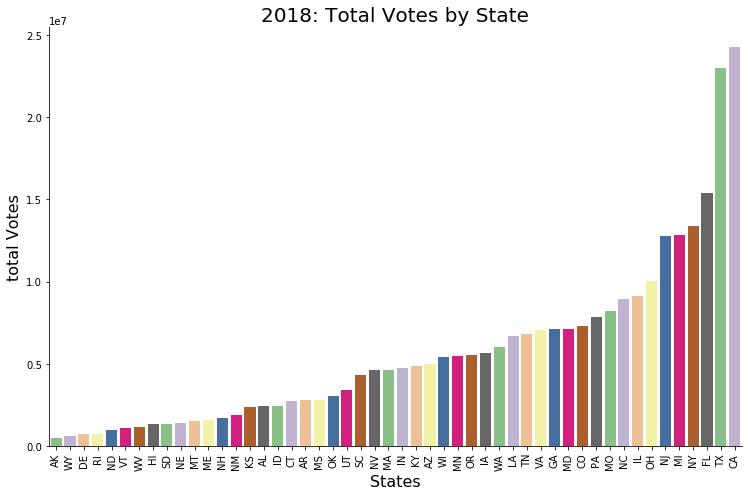

In [29]:
# Sort 2018 total votes data by vote count
df18votes_sort= df18votes.sort_values(by=['totalvotes'])

# Plot bar graph 
a = sn.catplot("CAND_OFFICE_ST", "totalvotes", data=df18votes_sort, kind="bar", size=7, aspect=1.5, legend=False, palette="Accent")
a.set_xticklabels(rotation=90)

plt.title('2018: Total Votes by State', size= "20")
plt.xlabel('States',size= "16")

plt.ylabel('total Votes',size= "16")          
plt.tight_layout()
plt.show()

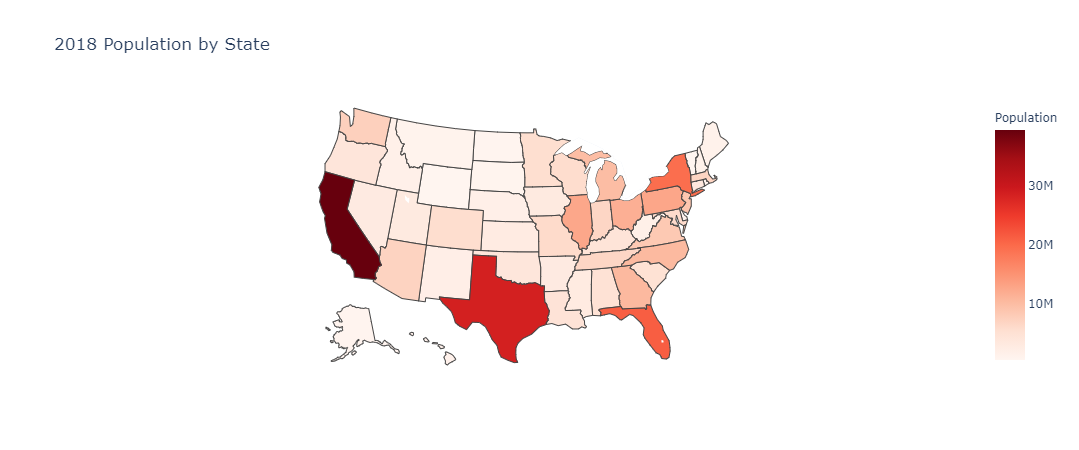

In [30]:
fig = go.Figure(data=go.Choropleth(
    locations=df18votes_sort.CAND_OFFICE_ST, # Spatial coordinates
    z = df18votes_sort.pop_2018, # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Population",
))

fig.update_layout(
    title_text = '2018 Population by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

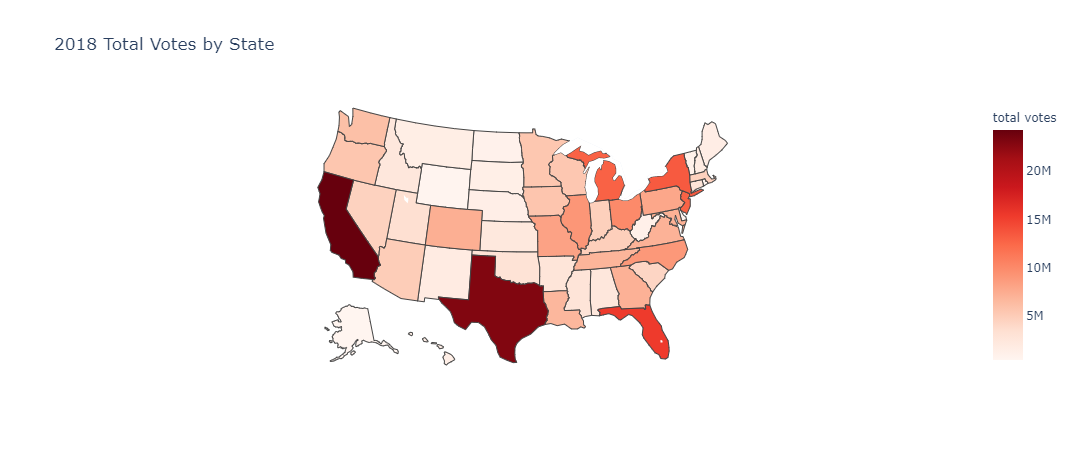

In [31]:
fig = go.Figure(data=go.Choropleth(
    locations=df18votes_sort.CAND_OFFICE_ST, # Spatial coordinates
    z = df18votes_sort.totalvotes, # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "total votes",
))

fig.update_layout(
    title_text = '2018 Total Votes by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3695: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



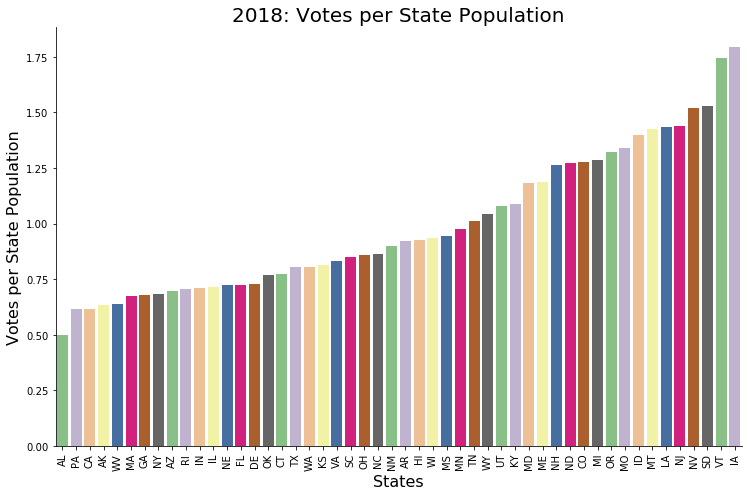

In [32]:
# Sort 2018 total votes data by vote count
df18votes_sort= df18votes.sort_values(by=['votes_per_pop18'])

# Plot bar graph 
a = sn.catplot("CAND_OFFICE_ST", "votes_per_pop18", data=df18votes_sort, kind="bar", size=7, aspect=1.5, legend=False, palette="Accent")
a.set_xticklabels(rotation=90)

plt.title('2018: Votes per State Population', size= "20")
plt.xlabel('States',size= "16")

plt.ylabel('Votes per State Population',size= "16")          
plt.tight_layout()
plt.show()

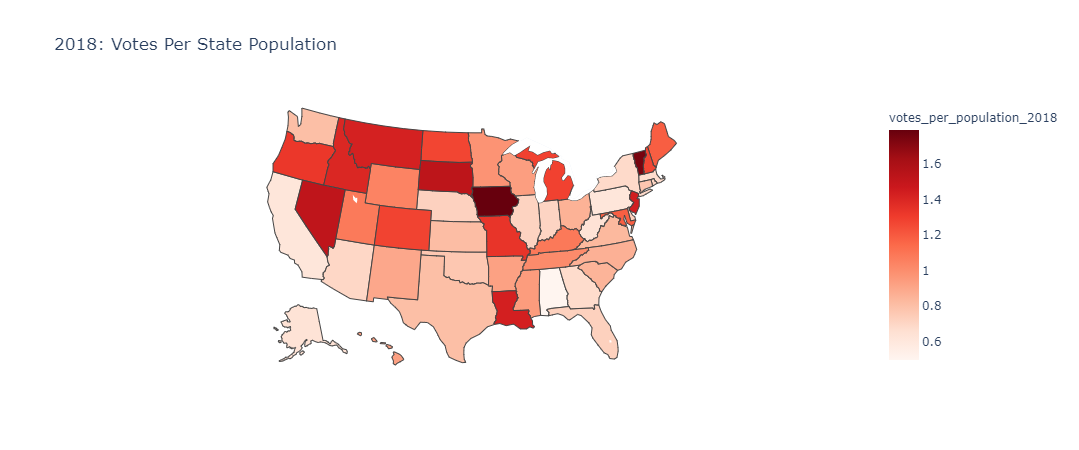

In [33]:
fig = go.Figure(data=go.Choropleth(
    locations=df18votes_sort.CAND_OFFICE_ST, # Spatial coordinates
    z = df18votes_sort.votes_per_pop18, # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "votes_per_population_2018",
))

fig.update_layout(
    title_text = '2018: Votes Per State Population',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

### 2016

In [34]:
df_house16 = df_candidate[(df_candidate.CAND_ELECTION_YR == '2016')&(df_candidate.CAND_OFFICE == 'H')]
df_house16 = df_house16.drop_duplicates(subset = ['CAND_ID']).reset_index(drop=True)

In [35]:
df_house16['CAND_ID'].groupby(df_house16.CAND_OFFICE).count()

CAND_OFFICE
H    2432
Name: CAND_ID, dtype: int64

In [36]:
#fuzzywuzzy match attempt between names in FEC/MIT data sets
df_house16['name_match'] = 0
df_house16['score_match'] = 0

name_match = []
score_match = []

for name in df_house16.CAND_NAME:
    ratio = process.extract(name, df_filter16.candidate, limit = 1, scorer=fuzz.token_set_ratio)
    name_match.append(ratio[0][0])
    score_match.append(ratio[0][1])   

df_house16['name_match'] = name_match
df_house16['score_match'] = score_match

In [37]:
df_house16.to_csv('16tempfile.csv')
df_filter16.to_csv('tempfile16.csv')

*2016 Data:*  
auto match = 877  
manual match = 233  
total match = 1110/1321

In [39]:
#re-uploaded
df_h16 = pd.read_excel('16tempfile.xlsx')
df_h16 = df_h16[df_h16.match == 1]

In [40]:
df_h16['CAND_ID'].count()

1093

In [41]:
df_h16_final = df_h16.merge(df_filter16, left_on='match_id', right_index=True)

In [42]:
df_h16_final.head()

CAND_ID                   CAND_NAME CAND_PTY_AFFILIATION  \
0  H6LA03122          RANTZ, AUGUST J IV                  REP   
1  H6VA04061  MCEACHIN, ASTON DONALD MR.                  DEM   
2  H4NJ10085        FRASER, AARON WALTER                  DEM   
3  H0CA27085                SCHIFF, ADAM                  DEM   
4  H0IL11052             KINZINGER, ADAM                  REP   

   CAND_ELECTION_YR CAND_OFFICE_ST CAND_OFFICE  CAND_OFFICE_DISTRICT CAND_ICI  \
0              2016             LA           H                   3.0        O   
1              2016             VA           H                   4.0        C   
2              2016             NJ           H                  10.0        C   
3              2016             CA           H                  28.0        I   
4              2016             IL           H                  16.0        I   

  CAND_STATUS   CAND_PCC  ... runoff special            candidate  \
0           P  C00609354  ...    NaN   False        ""Gus"" Rantz   
1           C  C00610964  ...    NaN   False   A. Donald McEachin   
2           N  C00668566  ...    NaN   False  Aaron Walter Fraser   
3           C  C00343871  ...    NaN   False       Adam B. Schiff   
4           C  C00458877  ...    NaN   False       Adam Kinzinger   

             party  writein   mode  candidatevotes  totalvotes  unofficial  \
0       republican    False  total           25662      282443       False   
1         democrat    False  total          200136      346656       False   
2  new beginning's    False  total            1746      222771       False   
3         democrat    False  total          210883      270409       False   
4       republican    False  total          259722      259853       False   

    version  
0  20200424  
1  20200424  
2  20200424  
3  20200424  
4  20200424  

[5 rows x 38 columns]

In [43]:
#Extract 2016 population data column
df_16pop = df_pop['2016']
aggregation_functions = {'totalvotes': 'sum'}
df16votes = df_h16_final[['CAND_OFFICE_ST']].join(df_h16_final[['totalvotes']]).reset_index()

df16votes  = df16votes .groupby(df_h16_final['CAND_OFFICE_ST']).aggregate(aggregation_functions).reset_index()
df16votes = df16votes.merge(df_pop)

df16votes['votes_per_pop16'] = df16votes['totalvotes']/df16votes['2016']

df16votes=df16votes[['CAND_OFFICE_ST','totalvotes','2016','votes_per_pop16']]
df16votes=df16votes.rename(columns={"2016": "pop_2016"})

df16votes

CAND_OFFICE_ST  totalvotes  pop_2016  votes_per_pop16
0              AK     1232792    741456         1.662664
1              AL     2803901   4863525         0.576516
2              AR     2439618   2989918         0.815948
3              AZ     4953803   6941072         0.713694
4              CA    26280808  39167117         0.670992
5              CO     8480731   5539215         1.531035
6              CT     4123805   3578141         1.152499
7              DE     1682468    948921         1.773033
8              FL    21533092  20613477         1.044612
9              GA     6107145  10301890         0.592818
10             HI     1302390   1427559         0.912320
11             IA     4201971   3131371         1.341895
12             ID     1689425   1682380         1.004188
13             IL     9893149  12820527         0.771665
14             IN     7720518   6634304         1.163727
15             KS     3521208   2910844         1.209686
16             KY     3057685   4438182         0.688950
17             LA    10357674   4678135         2.214061
18             MA     6844158   6823608         1.003012
19             MD     8819532   6003323         1.469108
20             ME     1543656   1331317         1.159495
21             MI    18671293   9950571         1.876404
22             MN     6453168   5522744         1.168471
23             MO     9382310   6087135         1.541334
24             MS     4729092   2987938         1.582728
25             MT     1523493   1040859         1.463688
26             NC     9547615  10154788         0.940208
27             ND     1015377    754434         1.345879
28             NE     1638120   1905616         0.859628
29             NH     2881447   1342307         2.146638
30             NJ    15019001   8870827         1.693078
31             NM     1560252   2091630         0.745950
32             NV     4313988   2917563         1.478627
33             NY    16624737  19633428         0.846757
34             OH    11477901  11634370         0.986551
35             OK     3109118   3926331         0.791863
36             OR     5752424   4089976         1.406469
37             PA    10644549  12782275         0.832759
38             RI     1321334   1056770         1.250352
39             SC     6055306   4957968         1.221328
40             SD      739946    862996         0.857415
41             TN     7753246   6646010         1.166602
42             TX    24338454  27914410         0.871896
43             UT     3334578   3041868         1.096227
44             VA     7572960   8410106         0.900460
45             VT      640934    623657         1.027703
46             WA     6000588   7294771         0.822588
47             WI     6770010   5772628         1.172778
48             WV     1580030   1831023         0.862922
49             WY     1035152    584215         1.771868

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3695: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



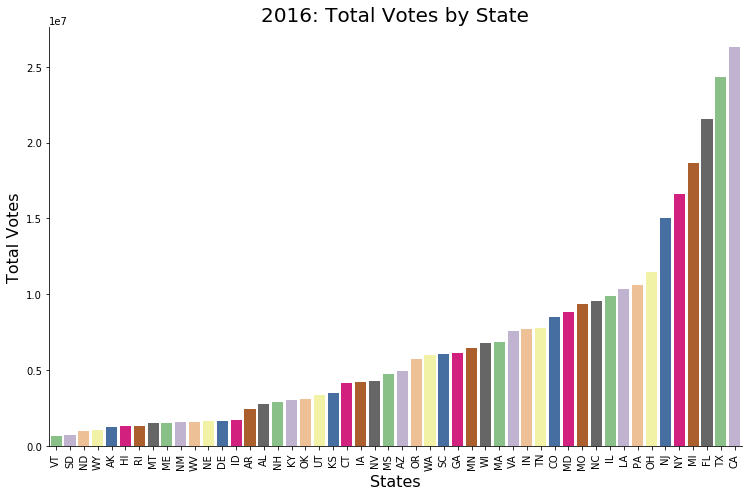

In [44]:
# Sort 2016 total votes data by vote count
df16votes_sort= df16votes.sort_values(by=['totalvotes'])

# Plot bar graph 
a = sn.catplot("CAND_OFFICE_ST", "totalvotes", data=df16votes_sort, kind="bar", size=7, aspect=1.5, legend=False, palette="Accent")
a.set_xticklabels(rotation=90)

plt.title('2016: Total Votes by State',size= "20")
plt.xlabel('States',size= "16")

plt.ylabel('Total Votes',size= "16")          
plt.tight_layout()
plt.show()

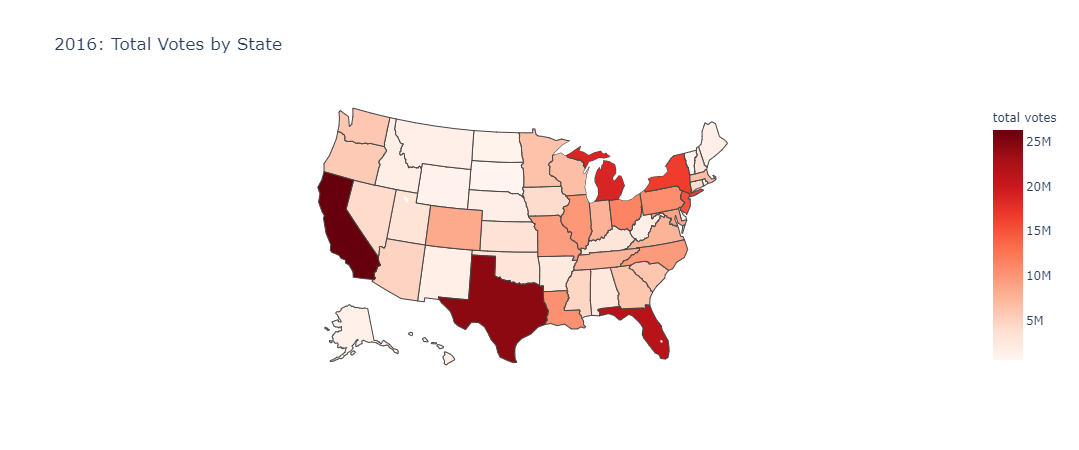

In [45]:
fig = go.Figure(data=go.Choropleth(
    locations=df16votes_sort.CAND_OFFICE_ST, # Spatial coordinates
    z = df16votes_sort.totalvotes, # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "total votes",
))

fig.update_layout(
    title_text = '2016: Total Votes by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3695: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



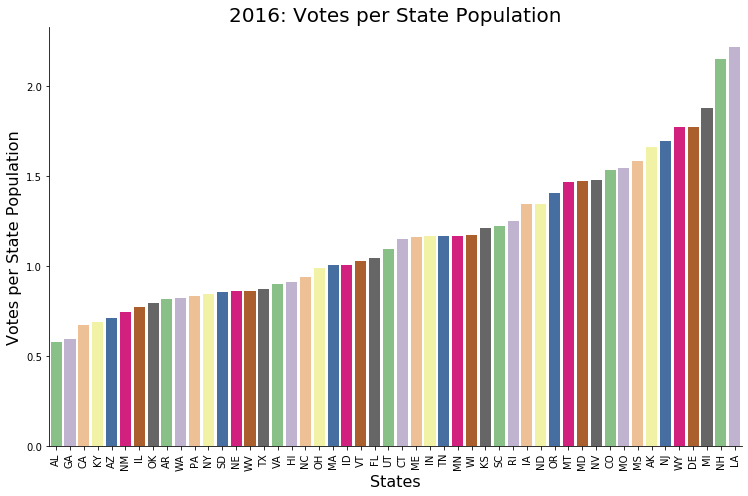

In [46]:
# Sort 2016 total votes data by vote count
df16votes_sort= df16votes.sort_values(by=['votes_per_pop16'])

# Plot bar graph 
a = sn.catplot("CAND_OFFICE_ST", "votes_per_pop16", data=df16votes_sort, kind="bar", size=7, aspect=1.5, legend=False, palette="Accent")
a.set_xticklabels(rotation=90)

plt.title('2016: Votes per State Population', size= "20")
plt.xlabel('States',size= "16")

plt.ylabel('Votes per State Population',size= "16")          
plt.tight_layout()
plt.show()

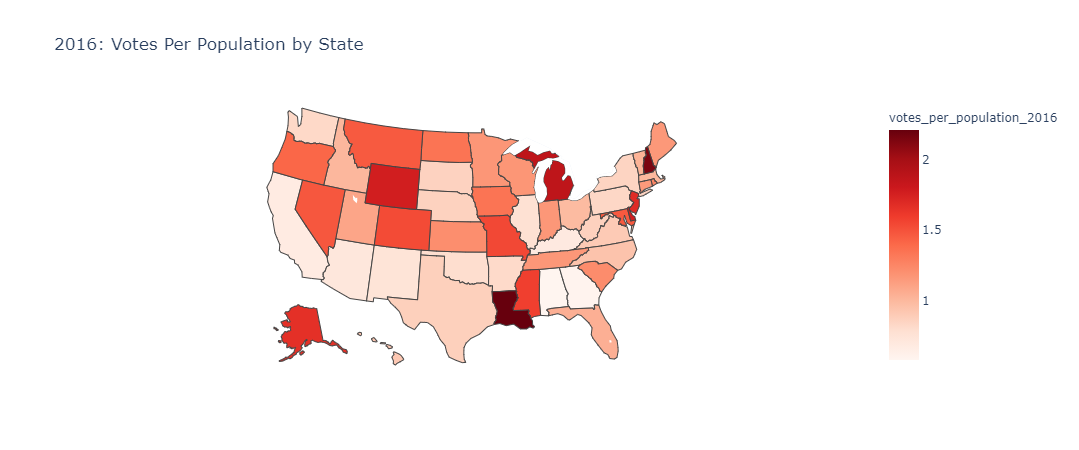

In [47]:
fig = go.Figure(data=go.Choropleth(
    locations=df16votes_sort.CAND_OFFICE_ST, # Spatial coordinates
    z = df16votes_sort.votes_per_pop16, # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "votes_per_population_2016",
))

fig.update_layout(
    title_text = '2016: Votes Per Population by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

In [50]:
df_h16_final['CAND_ID'].count()

1093

### Join 2016 and 2018

In [51]:
df_house = pd.concat([df_h16_final,df_h18_final])
df_house['VOTE_percent'] = df_house['candidatevotes']/df_house['totalvotes']

cols = ['CAND_ID',
        'CAND_NAME',
        'CAND_PTY_AFFILIATION',
        'CAND_ELECTION_YR',
        'CAND_OFFICE_ST',
        'CAND_OFFICE',
        'CAND_OFFICE_DISTRICT',
        'CAND_ICI',
        'CAND_STATUS',
        'CAND_PCC',
        'CAND_CITY',
        'CAND_ST',
        'CAND_ZIP',
        'candidatevotes',
        'totalvotes',
        'VOTE_percent']

df_house = df_house[cols]
df_house['WINNER'] = np.where(df_house['VOTE_percent'] >= 0.5, 1, 0)


In [52]:
df_house.head()

CAND_ID                   CAND_NAME CAND_PTY_AFFILIATION  \
0  H6LA03122          RANTZ, AUGUST J IV                  REP   
1  H6VA04061  MCEACHIN, ASTON DONALD MR.                  DEM   
2  H4NJ10085        FRASER, AARON WALTER                  DEM   
3  H0CA27085                SCHIFF, ADAM                  DEM   
4  H0IL11052             KINZINGER, ADAM                  REP   

   CAND_ELECTION_YR CAND_OFFICE_ST CAND_OFFICE  CAND_OFFICE_DISTRICT CAND_ICI  \
0              2016             LA           H                   3.0        O   
1              2016             VA           H                   4.0        C   
2              2016             NJ           H                  10.0        C   
3              2016             CA           H                  28.0        I   
4              2016             IL           H                  16.0        I   

  CAND_STATUS   CAND_PCC    CAND_CITY CAND_ST     CAND_ZIP  candidatevotes  \
0           P  C00609354    LAFAYETTE      LA      70598.0           25662   
1           C  C00610964      HENRICO      VA      23227.0          200136   
2           N  C00668566  JERSEY CITY      NJ       7305.0            1746   
3           C  C00343871  LOS ANGELES      CA      90017.0          210883   
4           C  C00458877    CHANNAHON      IL  604105623.0          259722   

   totalvotes  VOTE_percent  WINNER  
0      282443      0.090857       0  
1      346656      0.577333       1  
2      222771      0.007838       0  
3      270409      0.779867       1  
4      259853      0.999496       1

In [53]:
df_house.CAND_ID.count()

2159

In [54]:
len(df_house.CAND_ID.unique())

1735

In [55]:
df_house.WINNER.sum()

793

---
### Plotly Choropleth Maps:  
https://plotly.com/python/choropleth-maps/

In [56]:
import plotly.graph_objects as go
import pandas as pd

In [57]:
states_x50 = ['AS','DC','GU','PR','MP','VI']
temp_df = df_house[['CAND_OFFICE_ST','CAND_ID']].groupby('CAND_OFFICE_ST').count().reset_index()
temp_df = temp_df[~temp_df.CAND_OFFICE_ST.isin(states_x50)]

In [58]:
temp_df

CAND_OFFICE_ST  CAND_ID
0              AK        6
1              AL       22
2              AR       21
3              AZ       37
4              CA      209
5              CO       42
6              CT       23
7              DE        6
8              FL      118
9              GA       48
10             HI       13
11             IA       28
12             ID       13
13             IL       69
14             IN       45
15             KS       21
16             KY       28
17             LA       62
18             MA       34
19             MD       51
20             ME        9
21             MI       99
22             MN       35
23             MO       54
24             MS       28
25             MT        6
26             NC       58
27             ND        6
28             NE       12
29             NH       14
30             NJ      101
31             NM       14
32             NV       35
33             NY      120
34             OH       71
35             OK       25
36             OR       30
37             PA       62
38             RI       10
39             SC       39
40             SD        6
41             TN       57
42             TX      201
43             UT       25
44             VA       45
45             VT        6
46             WA       39
47             WI       36
48             WV       13
49             WY        7

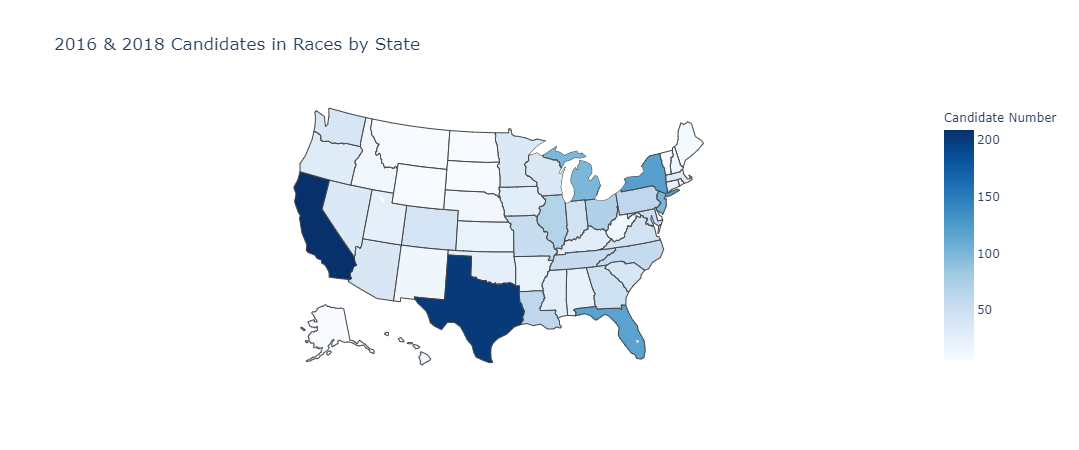

In [59]:
fig = go.Figure(data=go.Choropleth(
    locations=temp_df.CAND_OFFICE_ST, # Spatial coordinates
    z = temp_df.CAND_ID, # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "Candidate Number",
))

fig.update_layout(
    title_text = '2016 & 2018 Candidates in Races by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()